# Title: Alert Investigation (Process Alerts)
LogAnalytics
Version 0.3
## Description:
Series of modules designed to help get a better understanding of the contents of a process-based alert.


<a id='toc'></a>
## Table of Contents
- [Setup and Authenticate](#setup)

- [Get Alerts List](#getalertslist)
- [Choose an Alert to investigate](#enteralertid)
  - [Extract Properties and entities from alert](#extractalertproperties)
  - [Entity Graph](#entitygraph)
- [Related Alerts](#related_alerts)
- [Session Process Tree](#processtree)
  - [Process Timeline](#processtimeline)
- [Other Process on Host](#process_clustering)
- [Check for IOCs in Commandline](#cmdlineiocs)
  - [VirusTotal lookup](#virustotallookup)
- [Alert command line - Occurrence on other hosts in subscription](#cmdlineonotherhosts)
- [Host Logons](#host_logons)
  - [Alert Account](#logonaccount)
  - [Failed Logons](#failed_logons)
- [Appendices](#appendices)
  - [Saving data to Excel](#appendices)


<a id='setup'></a>[Contents](#toc)
# Setup

If you are running this from an Azure Notebooks instance created by Azure Sentinel you can ignore the package install step

1. Make sure that you have installed packages specified in the setup (uncomment the lines to execute)
2. There are some manual steps up to selecting the alert ID. After this most of the notebook can be executed sequentially
3. Major sections should be executable independently (e.g. Alert Command line and Host Logons can be run skipping Session Process Tree)

## Install Packages

In [ ]:
# You may needs these - should only need to uncomment and run once
# !pip install msgpack
# !pip install Kqlmagic --no-cache-dir  --upgrade

# !pip install PyHamcrest
# !conda install -c conda-forge python-levenshtein -y
# !conda install requests
# !conda install attrs
# !conda install seaborn
# !conda install bokeh
# !conda install holoviews

# our package
#!pip install ../python --upgrade


### Import Python Packags

In [11]:
# Imports
import sys
MIN_REQ_PYTHON = (3,6)
if sys.version_info < MIN_REQ_PYTHON:
    print('Check the Kernel->Change Kernel menu and ensure that Python 3.6')
    print('or later is selected as the active kernel.')
    sys.exit("Python %s.%s or later is required.\n" % MIN_REQ_PYTHON)


import numpy as np
from IPython import get_ipython
from IPython.display import display, HTML
import ipywidgets as widgets

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
sns.set()
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)

import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
   
import msticpy.sectools as sectools
import msticpy.nbtools as asi
import msticpy.nbtools.kql as qry
import msticpy.nbtools.nbdisplay as nbdisp


### Enter or confirm WorkspaceId

In [2]:
available_workspaces = {'Contoso77':'802d39e1-9d70-404d-832c-2de5e2478eda', 
                        'MSTICLinux':'06dc719f-5dad-47e9-b5af-07d84a0bda4e',
                        'ASIHuntOMSWorkspaceV4': '52b1ab41-869e-4138-9e40-2a4457f09bf0',
                        'ASIHuntOMSWorkspaceV5': '4ca7b24a-6e8f-4540-a8ce-1a80c2948c37',
                        'Rome ILDC - Detection E2E Tests Stage': '3eb61071-5dcd-4db3-94fa-0091a69b7359'}
select_ws = asi.SelectString(description='Select workspace :',
                             item_dict=available_workspaces)

select_ws.display()

Select(description='Select workspace :', layout=Layout(height='100px', width='50%'), options=('Contoso77', 'MS…

In [3]:
import os
from msticpy.nbtools.asiconfig import WorkspaceConfig
ws_config_file = 'config.json'
try:
    ws_config = WorkspaceConfig(ws_config_file)
    print('Found config file')
    for cf_item in ['tenant_id', 'subscription_id', 'resource_group', 'workspace_id', 'workspace_name']:
        print(cf_item, ws_config[cf_item])
except:
    ws_config = None
    
LA_URL = 'https://ms.portal.azure.com/#blade/HubsExtension/Resources/resourceType/Microsoft.OperationalInsights%2Fworkspaces'
help_str=f'To find your workspace Id go to <a href={LA_URL}>Log Analytics</a> and look at the workspace properties.'
display(HTML(help_str))

ws_id = asi.GetEnvironmentKey(env_var='WORKSPACE_ID',
                              prompt='Log Analytics Workspace Id:')
if ws_config:
    ws_id.value = ws_config['workspace_id']
ws_id.display()

HTML(value='')

### Authenticate to Log Analytics
If using user/device authentication, hit the 'Copy code to clipboard and authenticate' button. This will pop up an Azure Active Directory authentication dialog. The device code will have been copied to the clipboard. Paste that into the first dialog. You should then be redirected to a user authentication page where you should authenticate with a user account that has permission to query your Log Analytics workspace.

In [4]:
# TODO - set WS ID from dialog
if not select_ws.value and not ws_id.value:
    raise ValueError('No workspace selected.')
WORKSPACE_ID = select_ws.value

asi.kql.load_kql_magic()
# Use the following syntax if you are authenticating using an Azure Active Directory
# AppId and Secret
# %kql loganalytics://tenant(aad_tenant).workspace(WORKSPACE_ID).clientid(reader_client_id).clientsecret(reader_client_secret)

%kql loganalytics://code().workspace(WORKSPACE_ID)


<a id='getalertslist'></a>[Contents](#toc)
# Get Alerts List

Specify a time range to search for alerts. One this is set run the following cell to retrieve any alerts in that time window.
You can change the time range and re-run the queries until you find the alerts that you want.

In [5]:
alert_q_times = asi.QueryTime(units='day', max_before=20, before=5, max_after=1)
alert_q_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [27]:
alert_counts = qry.list_alerts_counts(provs=[alert_q_times])
alert_list = qry.list_alerts(provs=[alert_q_times])
print(len(alert_counts), ' distinct alert types')
print(len(alert_list), ' distinct alerts')
display(HTML('<h2>Alert Timeline</h2>'))
nbdisp.display_timeline(data=alert_list, source_columns = ['AlertName', 'CompromisedEntity'], title='Alerts', height=200)
display(HTML('<h2>Top alerts</h2>'))
alert_counts.head(20) # remove '.head(20)'' to see the full list grouped by AlertName

66  distinct alert types
189  distinct alerts


Loading BokehJS ...

,AlertName,alertCount,firstAlert,lastAlert
0,Suspicious Powershell Activity Detected,16,2019-01-15 05:15:14,2019-01-15 17:15:15
1,Suspicious process executed,11,2019-01-12 00:02:51,2019-01-15 17:15:19
2,Executable found running from a suspicious location,9,2019-01-15 05:15:20,2019-01-15 17:15:19
3,DC local group addition - Demo,6,2019-01-10 06:41:45,2019-01-15 06:41:46
4,Palo Alto admin logged on via SSH - Demo,6,2019-01-10 06:41:50,2019-01-15 06:41:55
5,DC with MS AM engine failure - Demo,6,2019-01-10 06:43:59,2019-01-15 06:44:00
6,Suspicious Account Added,6,2019-01-10 20:38:16,2019-01-15 22:28:16
7,Global domain trust creation - Demo,6,2019-01-10 05:48:09,2019-01-15 05:48:11
8,Maliciuos IP communication,6,2019-01-10 06:36:03,2019-01-15 06:36:02
9,Suspicious double extension file executed,6,2019-01-12 00:02:51,2019-01-15 17:15:23


<a id='enteralertid'></a>[Contents](#toc)
# Choose Alert to Investigate
Either pick an alert from a list of retrieved alerts or paste the SystemAlertId into the text box in the following section.

### Select alert from list
As you select an alert, the main properties will be shown below the list.

Use the filter box to narrow down your search to any substring in the AlertName.

In [28]:
alert_select = asi.AlertSelector(alerts=alert_list, action=nbdisp.display_alert)
alert_select.display()

### Or paste in an alert ID and fetch it
**Skip this if you selected from the above list**

In [29]:
# Allow alert to be selected
# Allow subscription to be selected
get_alert = asi.GetSingleAlert(action=nbdisp.display_alert)
get_alert.display()

<a id='extractalertproperties'></a>[Contents](#toc)
## Extract properties and entities from Alert
This section extracts the alert information and entities into a SecurityAlert object allowing us to query the properties more reliably. 

In particular, we use the alert to automatically provide parameters for queries and UI elements.
Subsequent queries will use properties like the host name and derived properties such as the OS family (Linux or Windows) to adapt the query. Query time selectors like the one above will also default to an origin time that matches the alert selected.

The alert view below shows all of the main properties of the alert plus the extended property dictionary (if any) and JSON representations of the Entity.

In [30]:
# Extract entities and properties into a SecurityAlert class
if alert_select.selected_alert is None:
    sys.exit("Please select an alert before executing remaining cells.")

security_alert = asi.SecurityAlert(alert_select.selected_alert)
asi.disp.display_alert(security_alert, show_entities=True)

,101
TenantId,802d39e1-9d70-404d-832c-2de5e2478eda
StartTimeUtc,2019-01-15 05:15:15
EndTimeUtc,2019-01-15 05:15:15
ProviderAlertId,265472ff-3820-4dad-8da7-00e39e1a99fd
SystemAlertId,2518547714843218505_265472ff-3820-4dad-8da7-00e39e1a99fd
ProviderName,Detection
VendorName,Microsoft
AlertType,Detected suspicious use of FTP -s Switch
AlertName,Detected suspicious use of FTP -s Switch
AlertDisplayName,Detected suspicious use of FTP -s Switch


{ 'HostName': 'MSTICALERTSWIN1',
  'NetBiosName': 'MSTICALERTSWIN1',
  'OSFamily': 'Windows',
  'Type': 'host'}
{ 'Directory': 'c:\\windows\\system32',
  'FullPath': 'c:\\windows\\system32\\cmd.exe',
  'Name': 'cmd.exe',
  'Type': 'file'}
{ 'Host': { 'HostName': 'MSTICALERTSWIN1',
            'NetBiosName': 'MSTICALERTSWIN1',
            'OSFamily': 'Windows',
            'Type': 'host'},
  'ImageFile': { 'Directory': 'c:\\windows\\system32',
                 'FullPath': 'c:\\windows\\system32\\cmd.exe',
                 'Name': 'cmd.exe',
                 'Type': 'file'},
  'ProcessId': '0xbc8',
  'Type': 'process'}
{ 'Host': { 'HostName': 'MSTICALERTSWIN1',
            'NetBiosName': 'MSTICALERTSWIN1',
            'OSFamily': 'Windows',
            'Type': 'host'},
  'LogonId': '0xfaac27',
  'NTDomain': 'MSTICAlertsWin1',
  'Name': 'MSTICAdmin',
  'Sid': 'S-1-5-21-996632719-2361334927-4038480536-500',
  'Type': 'account'}
{ 'Directory': 'c:\\diagnostics\\usertmp',
  'FullPath': 'c:\\

<a id='entitygraph'></a>[Contents](#toc)
## Entity Graph
Depending on the type of alert there may be one or more entities attached as properties. Entities are things like Host, Account, IpAddress, Process, etc. - essentially the 'nouns' of security investigation. Events and alerts are the things that link them in actions so can be thought of as the verbs. Entities are often related to other entities - for example a process will usually have a related file entity (the process image) and an Account entity (the context in which the process was running). Endpoint alerts typically always have a host entity (which could be a physical or virtual machine).

### Plot using Networkx/Matplotlib

C:\Users\Ian\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



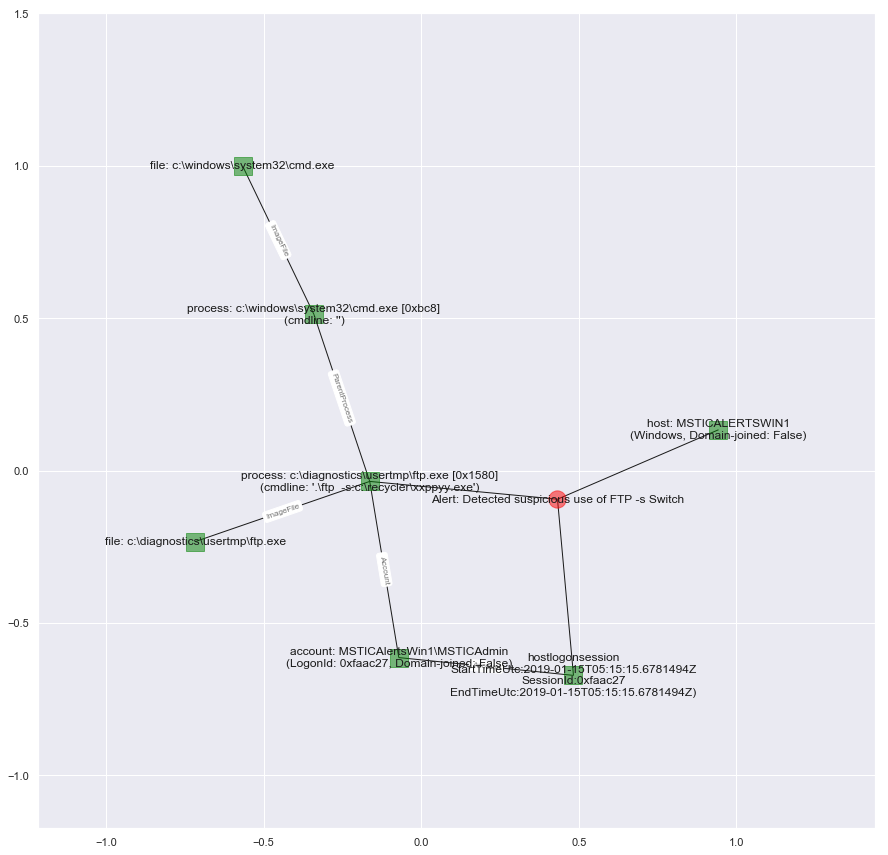

In [31]:
# Draw the graph using Networkx/Matplotlib
%matplotlib inline
alertentity_graph = asi.create_alert_graph(security_alert)
nbdisp.draw_alert_entity_graph(alertentity_graph, width=15)

In [41]:
# from pyvis.network import Network
# import math
# # import networkx as nx
# # G = Network()
# # G.from_nx(alertentity_graph)
# import holoviews as hv
# hv.extension('bokeh')
# %opts Graph [width=900 height=900]

# %opts Graph [color_index='circle']
# %opts Graph (node_size=20 edge_line_width=1)
# %opts Graph [tools=['wheel_zoom', 'hover']]
# padding = dict(x=(-1.2, 1.2), y=(-1.2, 1.2))

# n_nodes = len(alertentity_graph.nodes)
# k = 1 / (math.sqrt(n_nodes))

# # hv_graph = hv.Graph.from_networkx(nx_graph, nx.layout.spring_layout, k=k).redim.range(**padding)
# hv_graph = hv.Graph.from_networkx(alertentity_graph, nx.layout.spring_layout, k=k).redim.range(**padding)
# labels = hv.Labels(
#         {('x', 'y'): hv_graph.nodes.array([0, 1]), 'text': hv_graph.nodes.data['name']}, ## 'label' can be an array: has to be correct size!
#         ['x', 'y'], 
#         'text').options(fontsize=8, cmap='viridis', yoffset=0.05)
# hv_graph*labels

<a id='related_alerts'></a>[Contents](#toc)
# Related Alerts
For a subset of entities in the alert we can search for any alerts that have that entity in common. Currently this query looks for alerts that share the same Host, Account or Process and lists them below. 
**Notes:**
- Some alert types do not include all of these entity types.
- The original alert will be included in the "Related Alerts" set if it occurs within the query time boundary set below.

The query time boundaries default to a longer period than when searching for the alert. You can extend the time boundary searched before or after the alert time. If the widget doesn't support the time boundary that you want you can change the max_before and max_after parameters in the call to QueryTime below to extend the possible time boundaries.

In [32]:
# set the origin time to the time of our alert
query_times = asi.QueryTime(units='day', origin_time=security_alert.TimeGenerated, 
                            max_before=28, max_after=1, before=5)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [35]:
related_alerts = qry.list_related_alerts(provs=[query_times, security_alert])

host_alert_items = related_alerts\
    .query('host_match == @True')[['AlertType', 'StartTimeUtc']]\
    .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
acct_alert_items = related_alerts\
    .query('acct_match == @True')[['AlertType', 'StartTimeUtc']]\
    .groupby('AlertType').StartTimeUtc.agg('count').to_dict()
proc_alert_items = related_alerts\
    .query('proc_match == @True')[['AlertType', 'StartTimeUtc']]\
    .groupby('AlertType').StartTimeUtc.agg('count').to_dict()

def print_related_alerts(alertDict, entityType, entityName):
    if len(alertDict) > 0:
        print('Found {} different alert types related to this {} (\'{}\')'.format(len(alertDict), entityType, entityName))
        for (k,v) in alertDict.items():
            print('    {}, Count of alerts: {}'.format(k, v))
    else:
        print('No alerts for {} entity \'{}\''.format(entityType, entityName))

print_related_alerts(host_alert_items, 'host', security_alert.hostname)
print_related_alerts(acct_alert_items, 'account', 
                     security_alert.primary_account.qualified_name if security_alert.primary_account
                     else None)
print_related_alerts(proc_alert_items, 'process', 
                     security_alert.primary_process.ProcessFilePath if security_alert.primary_process
                     else None)
nbdisp.display_timeline(data=related_alerts, source_columns = ['AlertName'], title='Alerts', height=100)

Found 43 different alert types related to this host ('MSTICALERTSWIN1')
    Anomalous account creation detected, Count of alerts: 1
    Azure Security Center test alert (not a threat), Count of alerts: 5
    Detected Petya ransomware indicators, Count of alerts: 5
    Detected actions indicative of disabling and deleting IIS log files., Count of alerts: 1
    Detected anomalous mix of upper and lower case characters in command-line, Count of alerts: 4
    Detected change to a registry key that can be abused to bypass UAC, Count of alerts: 1
    Detected obfuscated command line., Count of alerts: 3
    Detected possible execution of keygen executable, Count of alerts: 1
    Detected possible execution of malware dropper, Count of alerts: 1
    Detected possible local reconnaissance activity, Count of alerts: 1
    Detected potentially suspicious use of Telegram tool, Count of alerts: 1
    Detected suspicious Set-ExecutionPolicy and WinRM changes, Count of alerts: 1
    Detected suspici

Loading BokehJS ...

### Show these related alerts on a graph
This should indicate which entities the other alerts are related to.

This can be unreadable with a lot of alerts. Use the matplotlib interactive zoom control to zoom in to part of the graph.

C:\Users\Ian\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning:

isinstance(..., numbers.Number)



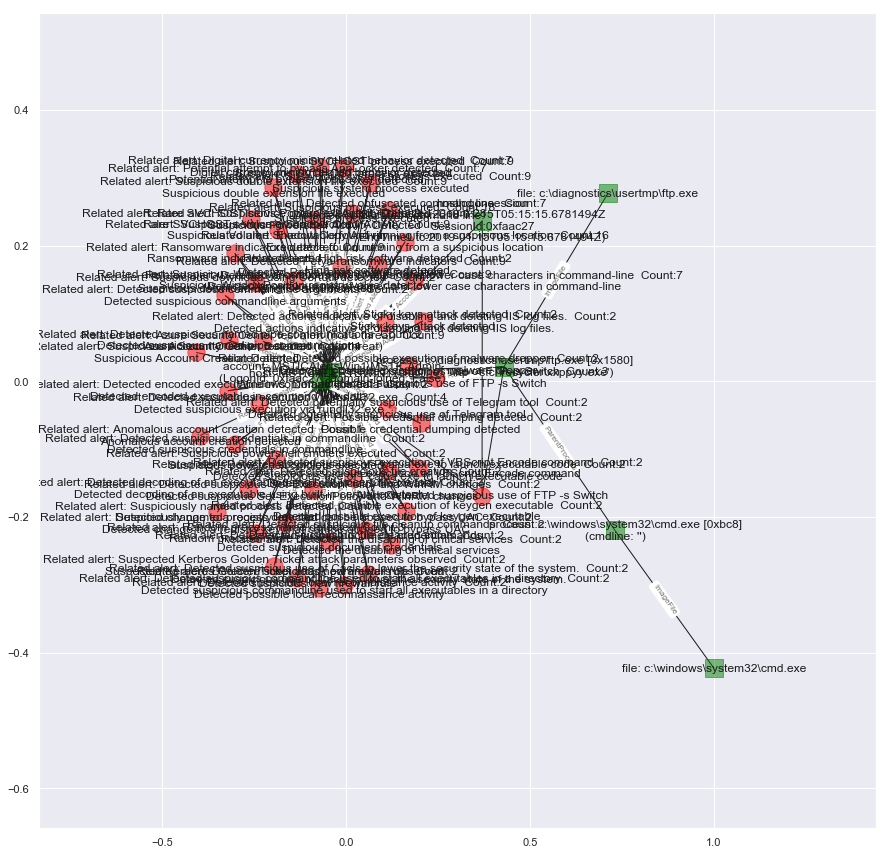

In [34]:
# Draw a graph of this (add to entity graph)
%matplotlib notebook
%matplotlib inline

rel_alert_graph = asi.add_related_alerts(related_alerts=related_alerts,
                                         alertgraph=alertentity_graph)
nbdisp.draw_alert_entity_graph(rel_alert_graph, width=15)

### Browse List of Related Alerts
Select an Alert to view details. 

If you want to investigate that alert - copy its *SystemAlertId* property and open a new instance of this notebook to investigate this alert.

In [36]:
related_alerts['CompromisedEntity'] = related_alerts['Computer']

def disp_full_alert(alert):
    global related_alert
    related_alert = asi.SecurityAlert(alert)
    nbdisp.display_alert(related_alert, show_entities=True)

print('Selected alert is available as \'related_alert\' variable.')
rel_alert_select = asi.AlertSelector(alerts=related_alerts, action=disp_full_alert)
rel_alert_select.display()


Selected alert is available as 'related_alert' variable.


<a id='processtree'></a>[Contents](#toc)
# Get Process Tree
If the alert has a process entity this section tries to retrieve the entire process tree to which that process belongs.

Notes:
- The alert must have a process entity
- Only processes started within the query time boundary will be included
- Ancestor and descented processes are retrieved to two levels (i.e. the parent and grandparent of the alert process plus any child and grandchild processes).
- Sibling processes are the processes that share the same parent as the alert process
- This can be a long-running query, especially if a wide time window is used! Caveat Emptor!

The source (alert) process is shown in red.

What's shown for each process:
- Each process line is indented according to its position in the tree hierarchy
- Top line fields:
  - \[relationship to source process:lev# - where # is the hops away from the source process\]
  - Process creation date-time (UTC)
  - Process Image path
  - PID - Process Id
  - SubjSess - the session Id of the process spawning the new process
  - TargSess - the new session Id if the process is launched in another context/session. If 0/0x0 then the process is launched in the same session as its parent
- Second line fields:
  - Process command line
  - Account - name of the account context in which the process is running

In [37]:
# set the origin time to the time of our alert
query_times = asi.QueryTime(units='minute', origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [38]:
if security_alert.primary_process and security_alert.primary_process.ProcessId:
    process_tree = qry.get_process_tree(provs=[query_times, security_alert])

    # Print out the text view of the process tree
    nbdisp.display_process_tree(process_tree)
else:
    print('This alert has no process entity. See later in the notebook to retrieve all processes')


<a id='processtimeline'></a>[Contents](#toc)
## Process TimeLine
This shows each process in the process tree on a timeline view.

Labelling of individual process is very performance intensive and often results in nothing being displayed at all! Besides, for large numbers of processes it would likely result in an unreadable mess. 

Your main tools for negotiating the timeline are the Hover tool (toggled on and off by the speech bubble icon) and the wheel-zoom and pan tools (the former is an icon with an elipse and a magnifying glass, the latter is the crossed-arrows icon). The wheel zoom is particularly useful.

As you hover over each process it will display the image name, PID and commandline.

Also shown on the graphic is the timestamp line of the source/alert process.

In [39]:
# Show timeline of events
nbdisp.display_timeline(data=process_tree, alert=security_alert, title='Alert Process Session', height=250)

Loading BokehJS ...

Alert start time =  2019-01-15 05:15:15


<a id='process_clustering'></a>[Contents](#toc)
# Other Processes on Host - Clustering
Sometimes you don't have a source process to work with. Other times it's just useful to see what else is going on on the host. This section retrieves all processes on the host within the time bounds
set in the query times widget.

You can display the raw output of this by looking at the *processes_on_host* dataframe. Just copy this into a new cell and hit Ctrl-Enter.

Usually though, the results return a lot of very repetitive and unintersting system processes so we attempt to cluster these to make the view easier to negotiate. 
To do this we process the raw event list output to extract a few features that render strings (such as commandline)into numerical values. The default below uses the following features:
- commandLineTokensFull - this is a count of common delimiters in the commandline 
  (given by this regex r'[\s\-\\/\.,"\'|&:;%$()]'). The aim of this is to capture the commandline structure while ignoring variations on what is essentially the same pattern (e.g. temporary path GUIDs, target IP or host names, etc.)
- pathScore - this sums the ordinal (character) value of each character in the path (so /bin/bash and /bin/bosh would have similar scores).
- isSystemSession - 1 if this is a root/system session, 0 if anything else.

Then we run a clustering algorithm (DBScan in this case) on the process list. The result groups similar (noisy) processes together and leaves unique process patterns as single-member clusters.

#### Clustered Processes (i.e. processes that have a cluster size > 1)

Number of input events: 363
Number of clustered events: 62


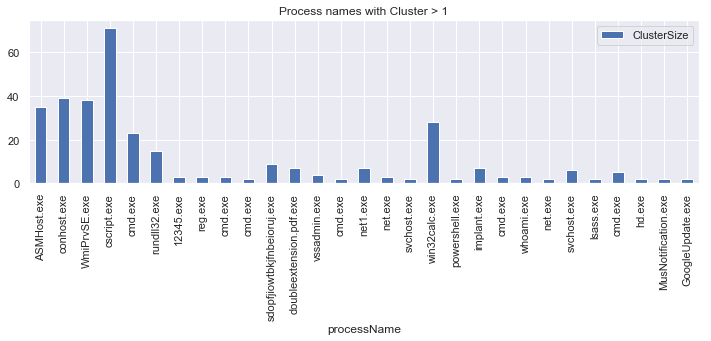

In [41]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features

processes_on_host = qry.list_processes(provs=[query_times, security_alert])
feature_procs = add_process_features(input_frame=processes_on_host,
                                     path_separator=security_alert.path_separator)


# you might need to play around with the max_cluster_distance parameter.
# decreasing this gives more clusters.
(clus_events, dbcluster, x_data) = dbcluster_events(data=feature_procs,
                                                    cluster_columns=['commandlineTokensFull', 
                                                                     'pathScore', 
                                                                     'isSystemSession'],
                                                    max_cluster_distance=0.0001)
print('Number of input events:', len(feature_procs))
print('Number of clustered events:', len(clus_events))
clus_events[['ClusterSize', 'processName']][clus_events['ClusterSize'] > 1].plot.bar(x='processName', 
                                                                                     title='Process names with Cluster > 1', 
                                                                                     figsize=(12,3));

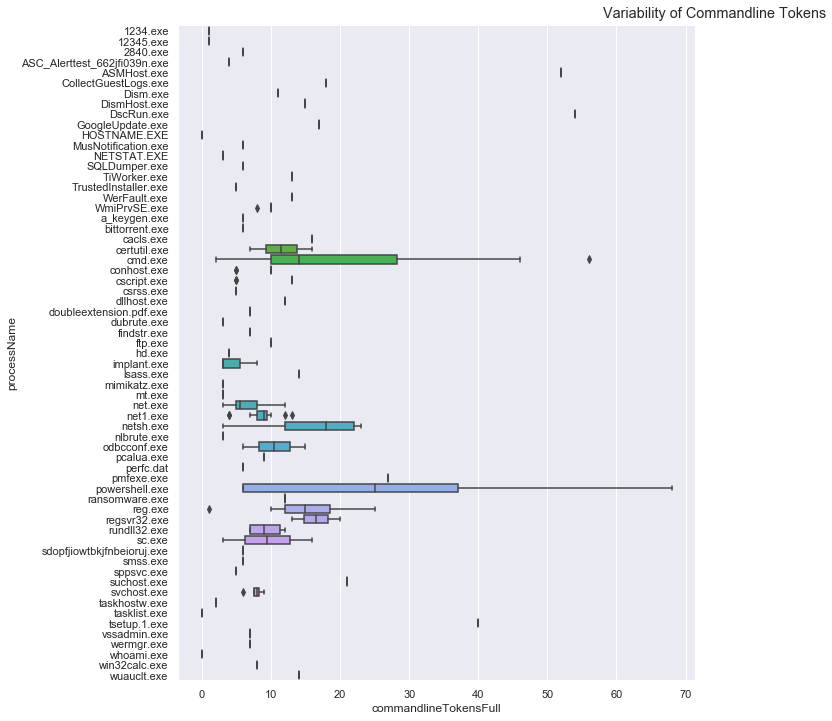

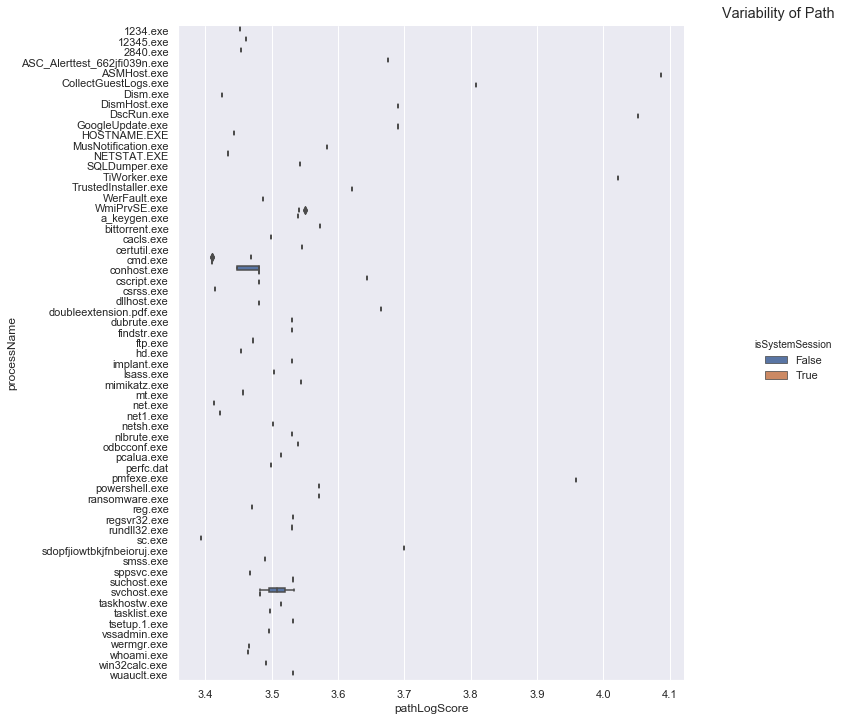

In [122]:
# Looking at the variability of commandlines and process image paths
import seaborn as sns
sns.set(style="darkgrid")

proc_plot = sns.catplot(y="processName", x="commandlineTokensFull", 
                        data=feature_procs.sort_values('processName'),
                        kind='box', height=10)
proc_plot.fig.suptitle('Variability of Commandline Tokens', x=1, y=1)

proc_plot = sns.catplot(y="processName", x="pathLogScore", 
                        data=feature_procs.sort_values('processName'),
                        kind='box', height=10, hue='isSystemSession')
proc_plot.fig.suptitle('Variability of Path', x=1, y=1);

The top graph shows that, for a given process, some have a wide variability in their command line content while the majority have little or none. Looking at a couple of examples - like cmd.exe, powershell.exe, reg.exe, net.exe - we can recognize several common command line tools.

The second graph shows processes by full process path content. We wouldn't normally expect to see variation here - as is the cast with most. There is also quite a lot of variance in the score making it a useful proxy feature for unique path name (this means that proc1.exe and proc2.exe that have the same commandline score won't get collapsed into the same cluster).

Any process with a spread of values here means that we are seeing the same process name (but not necessarily the same file) is being run from different locations.

In [43]:
resp = input('View the clustered data? y/n')
if resp == 'y':
    display(clus_events.sort_values('TimeGenerated')[['TimeGenerated', 'LastEventTime',
                                                      'NewProcessName', 'CommandLine', 
                                                      'ClusterSize', 'commandlineTokensFull',
                                                      'pathScore', 'isSystemSession']])

View the clustered data? y/ny


,TimeGenerated,LastEventTime,NewProcessName,CommandLine,ClusterSize,commandlineTokensFull,pathScore,isSystemSession
292,2019-01-15 04:23:43.103,2019-01-15 04:45:24.523,C:\Windows\System32\taskhostw.exe,taskhostw.exe SYSTEM,1.0,2,3262,True
270,2019-01-15 04:28:01.517,2019-01-15 04:28:33.090,C:\Program Files (x86)\Google\Update\GoogleUpdate.exe,"""C:\Program Files (x86)\Google\Update\GoogleUpdate.exe"" /ua /installsource scheduler",2.0,17,4895,True
133,2019-01-15 04:35:15.673,2019-01-15 04:45:24.523,C:\Windows\System32\sppsvc.exe,C:\Windows\system32\sppsvc.exe,1.0,5,2933,True
134,2019-01-15 04:35:16.060,2019-01-15 04:45:24.523,C:\Windows\System32\wbem\WmiPrvSE.exe,C:\Windows\system32\wbem\wmiprvse.exe -Embedding,1.0,8,3546,True
254,2019-01-15 04:42:25.437,2019-01-15 05:12:25.403,C:\Windows\System32\MusNotification.exe,C:\Windows\system32\MusNotification.exe Display,2.0,6,3826,True
256,2019-01-15 04:43:05.240,2019-01-15 04:45:24.523,C:\WindowsAzure\GuestAgent_2.7.41491.901_2019-01-14_202614\CollectGuestLogs.exe,"""CollectGuestLogs.exe"" -Mode:ga -FileName:C:\WindowsAzure\CollectGuestLogsTemp\710dc858-9c96-4df...",1.0,18,6421,True
301,2019-01-15 04:44:37.180,2019-01-15 04:45:24.523,C:\Windows\System32\cmd.exe,"""cmd""",1.0,2,2570,True
356,2019-01-15 04:45:24.523,2019-01-15 04:45:24.523,C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\Resources\222\pmfexe.exe,"""C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\Resources\222\pmfexe.exe...",1.0,27,9108,True
74,2019-01-15 05:15:03.017,2019-01-15 04:45:24.523,C:\Windows\System32\dllhost.exe,C:\Windows\system32\DllHost.exe /Processid:{E10F6C3A-F1AE-4ADC-AA9D-2FE65525666E},1.0,12,3024,True
75,2019-01-15 05:15:03.047,2019-01-15 04:45:24.523,C:\Windows\System32\cmd.exe,cmd.exe /c c:\Diagnostics\WindowsSimulateDetections.bat c:\Diagnostics\UserTmp,1.0,12,2570,True


In [44]:
# Look at clusters for individual process names
def view_cluster(exe_name):
    display(clus_events[['ClusterSize', 'processName', 'CommandLine', 'ClusterId']][clus_events['processName'] == exe_name])
view_cluster('reg.exe')

,ClusterSize,processName,CommandLine,ClusterId
46,1.0,reg.exe,.\reg not /domain:everything that /sid:shines is /krbtgt:golden !,-1.0
56,3.0,reg.exe,.\reg.exe add \hkcu\software\microsoft\some\key\Run /v abadvalue,7.0


In [ ]:
# Show all clustered processes

# Create label with unqualified path
labelled_df = processes_on_host.copy()
labelled_df['label'] = labelled_df.apply(lambda x: x.NewProcessName.split(security_alert.path_separator)[-1], axis=1)

%matplotlib inline
#%matplotlib notebook
plt.rcParams['figure.figsize'] = (15,10)
nbdisp.plot_cluster(dbcluster, labelled_df, x_data, plot_label='label', plot_features=[0,1], verbose=False, cut_off=3,
             xlabel='CmdLine Tokens', ylabel='Path Score');


### Time showing clustered vs. original data

In [46]:
# Show timeline of events - clustered events
nbdisp.display_timeline(data=clus_events, overlay_data=processes_on_host, 
                         alert=security_alert, title='Distinct Host Processes (top) and All Proceses (bottom)')

Loading BokehJS ...

Alert start time =  2019-01-15 05:15:15


<a id='cmdlineiocs'></a>[Contents](#toc)
# Base64 Decode and Check for IOCs
This section looks for Indicators of Compromise (IoC) within the data sets passed to it.

The first section looks at the commandline for the alert process (if any). It also looks for base64 encoded strings within the data - this is a common way of hiding attacker intent. It attempts to decode any strings that look like base64. Additionally, if the base64 decode operation returns any items that look like a base64 encoded string or file, a gzipped binary sequence, a zipped or tar archive, it will attempt to extract the contents before searching for potentially interesting items.

In [47]:
process = security_alert.primary_process
ioc_extractor = sectools.IoCExtract()

if process:
    # if nothing is decoded this just returns the input string unchanged
    base64_dec_str, _ = sectools.b64.unpack_items(input_string=process["CommandLine"])
    if base64_dec_str and '<decoded' in base64_dec_str:
        print('Base64 encoded items found.')
        print(base64_dec_str)
        
    # any IoCs in the string?
    iocs_found = ioc_extractor.extract(base64_dec_str)
    
    if iocs_found:
        print('\nPotential IoCs found in alert process:')
        display(iocs_found)
else:
    print('Nothing to process')



Potential IoCs found in alert process:


defaultdict(set, {'windows_path': {'.\\ftp', 'c:\\recycler\\xxppyy.exe'}})

### If we have a process tree, look for IoCs in the whole data set
You can replace the data=process_tree parameter to ioc_extractor.extract() to pass other data frames.
use the columns parameter to specify which column or columns that you want to search.

In [48]:
ioc_extractor = sectools.IoCExtract()
ioc_df = ioc_extractor.extract(data=process_tree, columns=['CommandLine'], os_family=security_alert.os_family)
if len(ioc_df):
    display(HTML("<h3>IoC patterns found in process tree.</h3>"))
    display(ioc_df)

,IoCType,Observable,SourceIndex
0,windows_path,C:\RECYCLER\xxppyy.exe,0
1,windows_path,.\ftp,0
2,windows_path,.\reg,1
3,windows_path,.\rundll32,3
4,windows_path,c:\users\MSTICAdmin\12345.exe,4
5,windows_path,.\rundll32,4
6,windows_path,.\rundll32,5
7,windows_path,.\rundll32,6
8,windows_path,c:\users\MSTICAdmin\1234.exe,6
9,windows_path,.\rundll32,7


### If any Base64 encoded strings, decode and search for IoCs in the results.
For simple strings the Base64 decoded output is straightforward. However for nested encodings this can get a little complex and difficult to represent in a tabular format.

**Columns**
 - reference - The index of the row item in dotted notation in depth.seq pairs (e.g. 1.2.2.3 would be the 3 item at depth 3 that is a child of the 2nd item found at depth 1). This may not always be an accurate notation - it is mainly use to allow you to associate an individual row with the reference value contained in the full_decoded_string column of the topmost item).
 - original_string - the original string before decoding.
 - file_name - filename, if any (only if this is an item in zip or tar file).
 - file_type - a guess at the file type (this is currently elementary and only includes a few file types).
 - input_bytes - the decoded bytes as a Python bytes string.
 - decoded_string - the decoded string if it can be decoded as a UTF-8 or UTF-16 string. Note: binary sequences may often successfully decode as UTF-16 strings but, in these cases, the decodings are meaningless.
 - encoding_type - encoding type (UTF-8 or UTF-16) if a decoding was possible, otherwise 'binary'.
 - file_hashes - collection of file hashes for any decoded item.
 - md5 - md5 hash as a separate column.
 - sha1 - sha1 hash as a separate column.
 - sha256 - sha256 hash as a separate column.
 - printable_bytes - printable version of input_bytes as a string of \xNN values
 - src_index - the index of the row in the input dataframe from which the data came.
 - full_decoded_string - the full decoded string with any decoded replacements. This is only really useful for top-level items, since nested items will only show the 'full' string representing the child fragment.

In [50]:
dec_df = sectools.b64.unpack_items(data=process_tree, column='CommandLine')
if len(dec_df) > 0:
    display(HTML("<h3>Decoded base 64 command lines</h3>"))
    display(HTML("Warning - some binary patterns may be decodable as unicode strings"))
    display(dec_df[['full_decoded_string', 'original_string', 'decoded_string', 'input_bytes', 'file_hashes']])

    ioc_dec_df = ioc_extractor.extract(data=dec_df, columns=['full_decoded_string'])
    if len(ioc_dec_df):
        display(HTML("<h3>IoC patterns found in base 64 decoded data</h3>"))
        display(ioc_dec_df)
        ioc_df = ioc_df.append(ioc_dec_df ,ignore_index=True)
else:
    print("No base64 encodings found.")

,full_decoded_string,original_string,decoded_string,input_bytes,file_hashes
0,.\powershell -enc <decoded type='string' name='[None]' index='1' depth='1'>$ t   =   ' d i r ' ...,JAB0ACAAPQAgACcAZABpAHIAJwA7AA0ACgAmACAAKAAnAEkAbgB2AG8AawBlACcAKwAnAC0ARQB4AHAAcgBlAHMAcwBpAG8A...,$ t   =   ' d i r ' ; \r \n &   ( ' I n v o k e ' + ' - E x p r e s s i o n ' )   $ t ,"b""$\x00t\x00 \x00=\x00 \x00'\x00d\x00i\x00r\x00'\x00;\x00\r\x00\n\x00&\x00 \x00(\x00'\x00I\x00n\...","{'md5': '6cd1486db221e532cc2011c9beeb4ffc', 'sha1': '6e485467d7e06502046b7c84a8ef067cfe1512ad', ..."
1,"cmd /c ""echo # <decoded type='string' name='[None]' index='1' depth='1'>ꙩ榚骦ꙩ榚骦ꙩ榚骦ꙩ榚骦</decoded> ...",aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,ꙩ榚骦ꙩ榚骦ꙩ榚骦ꙩ榚骦,b'i\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9a',"{'md5': '9a45b2520e930dc9186f6d93a7798a13', 'sha1': 'f526c90fa0744e3a63d84421ff25e3f5a3d697cb', ..."
2,"cmd /c ""echo # <decoded type='string' name='[None]' index='1' depth='1'>ꙩ榚骦ꙩ榚骦ꙩ榚骦ꙩ榚骦</decoded> ...",aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa,ꙩ榚骦ꙩ榚骦ꙩ榚骦ꙩ榚骦,b'i\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9ai\xa6\x9a',"{'md5': '9a45b2520e930dc9186f6d93a7798a13', 'sha1': 'f526c90fa0744e3a63d84421ff25e3f5a3d697cb', ..."
3,implant.exe <decoded type='string' name='[None]' index='1' depth='1'>埳펝᩷꽿해㣮컡槶믎彷絶岿</decoded>,81ed03caf6901e444c72ac67d192fb9c,埳펝᩷꽿해㣮컡槶믎彷絶岿,b'\xf3W\x9d\xd3w\x1a\x7f\xaft\xd5\xee8\xe1\xce\xf6i\xce\xbbw_v}\xbf\\',"{'md5': '1c8cc6299bd654bbcd85710968d6a87c', 'sha1': '55377391141f59a2ff5ae4765d9f0b4438adfd73', ..."


,IoCType,Observable,SourceIndex
0,windows_path,.\powershell,0


<a id='virustotallookup'></a>[Contents](#toc)
## Virus Total Lookup
This section uses the popular Virus Total service to check any recovered IoCs against VTs database.

To use this you need an API key from virus total, which you can obtain here: https://www.virustotal.com/.

Note that VT throttles requests for free API keys to 4/minute. If you are unable to process the entire data set, try splitting it and submitting smaller chunks.

**Things to note:**
- Virus Total lookups include file hashes, domains, IP addresses and URLs.
- The returned data is slightly different depending on the input type
- The VTLookup class tries to screen input data to prevent pointless lookups. E.g.:
  - Only public IP Addresses will be submitted (no loopback, private address space, etc.)
  - URLs with only local (unqualified) host parts will not be submitted.
  - Domain names that are unqualified will not be submitted.
  - Hash-like strings (e.g 'AAAAAAAAAAAAAAAAAA') that do not appear to have enough entropy to be a hash will not be submitted.

**Output Columns**
 - Observable - The IoC observable submitted
 - IoCType - the IoC type
 - Status - the status of the submission request
 - ResponseCode - the VT response code
 - RawResponse - the entire raw json response
 - Resource - VT Resource
 - SourceIndex - The index of the Observable in the source DataFrame. You can use this to rejoin to your original data.
 - VerboseMsg - VT Verbose Message
 - ScanId - VT Scan ID if any
 - Permalink - VT Permanent URL describing the resource
 - Positives - If this is not zero, it indicates the number of malicious reports that VT holds for this observable.
 - MD5 - The MD5 hash, if any
 - SHA1 - The MD5 hash, if any
 - SHA256 - The MD5 hash, if any
 - ResolvedDomains - In the case of IP Addresses, this contains a list of all domains that resolve to this IP address
 - ResolvedIPs - In the case Domains, this contains a list of all IP addresses resolved from the domain.
 - DetectedUrls - Any malicious URLs associated with the observable.

In [51]:
vt_key = asi.GetEnvironmentKey(env_var='VT_API_KEY',
                           help_str='To obtain an API key sign up here https://www.virustotal.com/',
                           prompt='Virus Total API key:')
vt_key.display()

HTML(value='To obtain an API key sign up here https://www.virustotal.com/')

In [ ]:
if vt_key.value:
    vt_lookup = sectools.VTLookup(vt_key.value, verbosity=2)

    print(f'{len(ioc_df)} items in input frame')
    supported_counts = {}
    for ioc_type in vt_lookup.supported_ioc_types:
        supported_counts[ioc_type] = len(ioc_df[ioc_df['IoCType'] == ioc_type])
    print('Items in each category to be submitted to VirusTotal')
    print('(Note: items have pre-filtering to remove obvious erroneous '
          'data and false positives, such as private IPaddresses)')
    print(supported_counts)
    print('-' * 80)
    vt_results = vt_lookup.lookup_iocs(data=ioc_df, type_col='IoCType', src_col='Observable')
    display(vt_results)

<a id='cmdlineonotherhosts'></a>[Contents](#toc)
# Alert command line - Occurrence on other hosts in workspace
To get a sense of whether the alert process is something that is occuring on other hosts, run this section.

This might tell you that the alerted process is actually a commonly-run process and the alert is a false positive. Alternatively, it may tell you that a real infection or attack is happening on other hosts in your environment.

In [52]:
# set the origin time to the time of our alert
query_times = asi.QueryTime(units='day', before=5, max_before=20,
                            after=1, max_after=10,
                            origin_time=security_alert.origin_time)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

In [53]:
# API ILLUSTRATION - Find the query to use
qry.list_queries()

['list_alerts_counts',
 'list_alerts',
 'get_alert',
 'list_related_alerts',
 'list_related_ip_alerts',
 'get_process_tree',
 'list_processes',
 'get_process_parent',
 'list_hosts_matching_commandline',
 'list_processes_in_session',
 'get_host_logon',
 'list_host_logons',
 'list_host_logon_failures']

In [54]:
# API ILLUSTRATION - What does the query look like?
qry.query_help('list_hosts_matching_commandline')

Query:  list_hosts_matching_commandline
Retrieves processes on other hosts with matching commandline
Designed to be executed with data_source:  process_create
Supported data families:  DataFamily.WindowsSecurity, DataFamily.LinuxSecurity
Supported data environments:  DataEnvironment.LogAnalytics
Query parameters:
['end', 'process_name', 'host_filter_neq', 'subscription_filter', 'add_query_items', 'start', 'commandline']
Optional parameters:
add_query_items
Query:
{table}
{query_project}
| where {subscription_filter}
| where {host_filter_neq}
| where TimeGenerated >= datetime({start})
| where TimeGenerated <= datetime({end})
| where NewProcessName endswith '{process_name}'
| where CommandLine =~ '{commandline}'
{add_query_items}


In [56]:
# This query needs a commandline parameter which isn't supplied
# by default from the the alert 
# - so extract and escape this from the process
commandline = security_alert.primary_process.CommandLine
commandline = asi.utility.escape_windows_path(commandline)
#commandline = commandline.replace('\'', '\\\'')
proc_match_in_ws = qry.list_hosts_matching_commandline(provs=[query_times, security_alert],
                                                                commandline=commandline)

# Check the results
if proc_match_in_ws is None or len(proc_match_in_ws) == 0:
    print('No proceses with matching commandline found in on other hosts in workspace')
    print('between', query_times.start, 'and', query_times.end)
else:
    hosts = proc_match_in_ws['Computer'].drop_duplicates().shape[0]
    processes = proc_match_in_ws.shape[0]
    print('{numprocesses} proceses with matching commandline found on {numhosts} hosts in workspace'\
         .format(numprocesses=processes, numhosts=hosts))
    print('between', query_times.start, 'and', query_times.end)
    print('To examine these execute the dataframe \'{}\' in a new cell'.format('proc_match_in_ws'))
    print(proc_match_in_ws[['TimeCreatedUtc','Computer', 'NewProcessName', 'CommandLine']].head())
    

No proceses with matching commandline found in on other hosts in workspace
between 2019-01-10 05:15:20 and 2019-01-16 05:15:20


<a id='host_logons'></a>[Contents](#toc)
# Host Logons
This section retrieves the logon events on the host in the alert.

You may want to use the query times to search over a broader range than the default.

In [57]:
# set the origin time to the time of our alert
query_times = asi.QueryTime(units='day', origin_time=security_alert.origin_time,
                           before=5, after=0, max_before=20, max_after=1)
query_times.display()

HTML(value='<h4>Set query time boundaries</h4>')

<a id='logonaccount'></a>[Contents](#toc)
## Alert Logon Account
The logon associated with the process in the alert.

In [58]:
if security_alert.primary_account:
    logon_event = qry.get_host_logon(provs=[query_times, security_alert])
    nbdisp.display_logon_data(logon_event, security_alert)
else:
    print('No account entity in the source alert.')

### Account Logon
Account:  MSTICAdmin
Account Domain:  MSTICAlertsWin1
Logon Time:  2019-01-15 05:15:02.980000
Logon type: 4 (Batch)
User Id/SID:  S-1-5-21-996632719-2361334927-4038480536-500
    SID S-1-5-21-996632719-2361334927-4038480536-500 is administrator
    SID S-1-5-21-996632719-2361334927-4038480536-500 is local machine or domain account
Session id '0xfaac27'  
Subject (source) account:  WORKGROUP/MSTICAlertsWin1$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  MSTICAlertsWin1
Logon status:  



### All Host Logons
Since the number of logon events may be large and, in the case of system logons, very repetitive, we use clustering to try to identity logons with unique characteristics.

In this case we use the numeric score of the account name and the logon type (i.e. interactive, service, etc.). The results of the clustered logons are shown below along with a more detailed, readable printout of the logon event information. The data here will vary depending on whether this is a Windows or Linux host.

In [59]:
from msticpy.sectools.eventcluster import dbcluster_events, add_process_features, _string_score

host_logons = qry.list_host_logons(provs=[query_times, security_alert])
if len(host_logons) > 0:
    logon_features = host_logons.copy()
    logon_features['AccountNum'] = host_logons.apply(lambda x: _string_score(x.Account), axis=1)
    logon_features['LogonHour'] = host_logons.apply(lambda x: x.TimeGenerated.hour, axis=1)

    # you might need to play around with the max_cluster_distance parameter.
    # decreasing this gives more clusters.
    (clus_logons, _, _) = dbcluster_events(data=logon_features, time_column='TimeGenerated',
                                           cluster_columns=['AccountNum',
                                                            'LogonType'],
                                                             max_cluster_distance=0.0001)
    print('Number of input events:', len(host_logons))
    print('Number of clustered events:', len(clus_logons))
    print('\nDistinct host logon patterns:')
    display(clus_logons.sort_values('TimeGenerated'))
else:
    print('No logon events found for host.')

Number of input events: 14
Number of clustered events: 3

Distinct host logon patterns:


,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName,AccountNum,LogonHour,Clustered,ClusterId,ClusterSize,LastEventTime
0,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\MSTICAdmin,4624,2019-01-15 05:15:02.980,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,MSTICAdmin,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-500,0xfaac27,Advapi,4,Negotiate,,-,MSTICAlertsWin1,2319,5,True,0.0,2.0,2019-01-15 04:28:33.090
1,802d39e1-9d70-404d-832c-2de5e2478eda,NT AUTHORITY\SYSTEM,4624,2019-01-15 05:15:04.503,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,MSTICAlertsWin1$,WORKGROUP,S-1-5-18,SYSTEM,NT AUTHORITY,S-1-5-18,0x3e7,Advapi,5,Negotiate,,-,-,1484,5,True,1.0,11.0,2019-01-15 03:09:51.707
2,802d39e1-9d70-404d-832c-2de5e2478eda,MSTICAlertsWin1\adm1nistrator,4624,2019-01-15 05:15:06.363,46fe7078-61bb-4bed-9430-7ac01d91c273,MSTICAlertsWin1,-,-,S-1-0-0,adm1nistrator,MSTICAlertsWin1,S-1-5-21-996632719-2361334927-4038480536-1066,0xfb5ee6,NtLmSsp,3,NTLM,,fe80::38dc:e4a9:61bd:b458,MSTICAlertsWin1,2799,5,False,-1.0,1.0,2019-01-15 05:15:06.363


In [60]:
# Display logon details
nbdisp.display_logon_data(clus_logons, security_alert)

### Account Logon
Account:  adm1nistrator
Account Domain:  MSTICAlertsWin1
Logon Time:  2019-01-15 05:15:06.363000
Logon type: 3 (Network)
User Id/SID:  S-1-5-21-996632719-2361334927-4038480536-1066
    SID S-1-5-21-996632719-2361334927-4038480536-1066 is local machine or domain account
Session id '0xfb5ee6'  
Subject (source) account:  -/-
Logon process:  NtLmSsp 
Authentication:  NTLM
Source IpAddress:  fe80::38dc:e4a9:61bd:b458
Source Host:  MSTICAlertsWin1
Logon status:  

### Account Logon
Account:  MSTICAdmin
Account Domain:  MSTICAlertsWin1
Logon Time:  2019-01-15 05:15:02.980000
Logon type: 4 (Batch)
User Id/SID:  S-1-5-21-996632719-2361334927-4038480536-500
    SID S-1-5-21-996632719-2361334927-4038480536-500 is administrator
    SID S-1-5-21-996632719-2361334927-4038480536-500 is local machine or domain account
Session id '0xfaac27'  
Subject (source) account:  WORKGROUP/MSTICAlertsWin1$
Logon process:  Advapi  
Authentication:  Negotiate
Source IpAddress:  -
Source Host:  MS

### Comparing All Logons with Clustered results relative to Alert time line

In [61]:
# Show timeline of events - all logons + clustered logons
nbdisp.display_timeline(data=host_logons, overlay_data=clus_logons,
                         alert=security_alert, 
                         source_columns=['Account', 'LogonType'],
                         title='All Host Logons')

Loading BokehJS ...

Alert start time =  2019-01-15 05:15:15


### View Process Session and Logon Events in Timelines
This shows the timeline of the clustered logon events with the process tree obtained earlier. This allows you to get a sense of which logon was responsible for the process tree session whether any additional logons (e.g. creating a process as another user) might be associated with the alert timeline.

*Note you should use the pan and zoom tools to align the timelines since the data may be over different time ranges.*

In [64]:
# Show timeline of events - all events
nbdisp.display_timeline(data=clus_logons, source_columns=['Account', 'LogonType'],
                         alert=security_alert,
                         title='Clustered Host Logons', height=200)
nbdisp.display_timeline(data=process_tree, alert=security_alert, title='Alert Process Session', height=200)

Loading BokehJS ...

Alert start time =  2019-01-15 05:15:15


Loading BokehJS ...

Alert start time =  2019-01-15 05:15:15


In [65]:
# Counts of Logon types by Account
host_logons[['Account', 'LogonType', 'TimeGenerated']].groupby(['Account','LogonType']).count()

,,TimeGenerated
Account,LogonType,
MSTICAlertsWin1\MSTICAdmin,4,2
MSTICAlertsWin1\adm1nistrator,3,1
NT AUTHORITY\SYSTEM,5,11


<a id='failed logons'></a>[Contents](#toc)
## Failed Logons

In [66]:
failedLogons = qry.list_host_logon_failures(provs=[query_times, security_alert])
if failedLogons.shape[0] == 0:
    display(print('No logon failures recorded for this host between {security_alert.start} and {security_alert.start}'))

failedLogons

No logon failures recorded for this host between {security_alert.start} and {security_alert.start}


None

,TenantId,Account,EventID,TimeGenerated,SourceComputerId,Computer,SubjectUserName,SubjectDomainName,SubjectUserSid,TargetUserName,TargetDomainName,TargetUserSid,TargetLogonId,LogonProcessName,LogonType,AuthenticationPackageName,Status,IpAddress,WorkstationName


<a id='appendices'></a>[Contents](#toc)
# Appendices

## Available DataFrames

In [67]:
print('List of current DataFrames in Notebook')
print('-' * 50)
current_vars = list(locals().keys())
for var_name in current_vars:
    if isinstance(locals()[var_name], pd.DataFrame) and not var_name.startswith('_'):
        print(var_name)

List of current DataFrames in Notebook
--------------------------------------------------
alert_counts
alert_list
related_alerts
processes_on_host
labelled_df
process_tree
feature_procs
clus_events
ioc_df
dec_df
ioc_dec_df
proc_match_in_ws
logon_event
host_logons
logon_features
clus_logons
failedLogons


## Saving Data to Excel
To save the contents of a pandas DataFrame to an Excel spreadsheet
use the following syntax
```
writer = pd.ExcelWriter('myWorksheet.xlsx')
my_data_frame.to_excel(writer,'Sheet1')
writer.save()
```